In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
#
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#
from sklearn.preprocessing import LabelEncoder
make_lb = LabelEncoder()
#
from sklearn.preprocessing import LabelBinarizer
lbb = LabelBinarizer()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
from sklearn.linear_model import LogisticRegression

# Data Cleaning & Exploration

In [11]:
df = pd.read_csv('student_data.csv')

In [12]:
df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.columns=df.columns.str.lower()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 25 columns):
id           23999 non-null int64
limit_bal    23999 non-null int64
sex          23999 non-null int64
education    23999 non-null int64
marriage     23999 non-null int64
age          23999 non-null int64
pay_0        23999 non-null int64
pay_2        23999 non-null int64
pay_3        23999 non-null int64
pay_4        23999 non-null int64
pay_5        23999 non-null int64
pay_6        23999 non-null int64
bill_amt1    23999 non-null int64
bill_amt2    23999 non-null int64
bill_amt3    23999 non-null int64
bill_amt4    23999 non-null int64
bill_amt5    23999 non-null int64
bill_amt6    23999 non-null int64
pay_amt1     23999 non-null int64
pay_amt2     23999 non-null int64
pay_amt3     23999 non-null int64
pay_amt4     23999 non-null int64
pay_amt5     23999 non-null int64
pay_amt6     23999 non-null int64
default      23999 non-null int64
dtypes: int64(25)
memory usage: 4.6 MB


#### For Reference

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.  

Found this to only be slightly helpful. Not so much cleaning but more wrangling will be involved.

In [14]:
df['default'].value_counts()

0    18691
1     5308
Name: default, dtype: int64

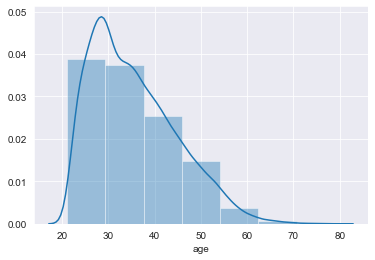

In [15]:
# Viewing the distribution of age in the data
sns.distplot(df['age'], bins = 7)

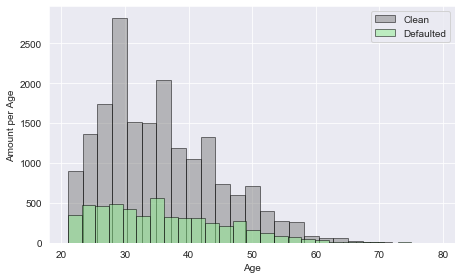

In [16]:
# Plotting total number 'clean' with the total number 'defaulted' over it
# There is a bit of a misalignment with the distribution
# Ages should be binned
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df['default'] ==0].age, bins = 25, label ='Clean', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(df[df['default']==1].age, bins = 25, label = 'Defaulted', alpha = .50, edgecolor = 'black',color = 'lightgreen')
ax1.set_xlabel('Age')
ax1.set_ylabel('Amount per Age')
ax1.legend(loc = 'upper right')

In [17]:
# Binning then getting dummies for age groups

df['age_bin'] = pd.cut(df['age'], 6, labels=['20s', '30s', '40s', '50s', '60s', '70s'])
df[['age', 'age_bin']]
dums = pd.get_dummies(df['age_bin'], drop_first=True)
df.drop(columns=['age'], axis=1, inplace=True)
dums = pd.get_dummies(df['age_bin'], drop_first=True)
df = df.join(dums)

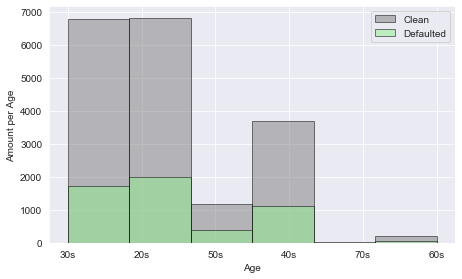

In [18]:
###### sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(221)
ax1.hist(df[df['default'] ==0].age_bin, bins = 6, label ='Clean', alpha = .50,edgecolor= 'black',color ='grey')
ax1.hist(df[df['default']==1].age_bin, bins = 6, label = 'Defaulted', alpha = .50, edgecolor = 'black',color = 'lightgreen')
ax1.set_xlabel('Age')
ax1.set_ylabel('Amount per Age')
ax1.legend(loc = 'upper right')

A bit wonky but still gives a good idea of how the `default` classification is spread out throughout age groups. Those between 20-40 make up most of this data.

In [19]:
# Can now delete the `age_bin` column since we have dummies
df.drop(columns=['age_bin'], axis=1, inplace=True)

In [20]:
# Making sex a binary term
# Dropping the `sex` column and replacing with gender
gender = []
for x in df['sex']:
    if x == 1:
        gender.append(1)
    elif x == 2:
        gender.append(0)

df['gender'] = gender
df.drop(columns=['sex'], axis=1, inplace=True)

In [21]:
# Since I don't know what is above 4 in regards to education, I am going to bin 
# All of the education types into their labeled types, except all above 4 are `others`
# Making dummies for the different education levels

df['edu'] = pd.cut(df['education'], 4, labels=['grad', 'undergrad', 'highschool', 'others'])
df[['edu', 'education']]
dums = pd.get_dummies(df['edu'], drop_first=True)
df.drop(columns=['education'], axis=1, inplace=True)

In [22]:
# Adding the dummies, dropping the old column
df = df.join(dums)
df.drop(columns=['edu'], axis=1, inplace=True)

In [23]:
df.drop(columns=['marriage', 'id',], axis=1, inplace=True)

In [24]:
# Manually MinMax scaling the continuous columns
# Normalization

col_to_norm = ['limit_bal', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
df[col_to_norm] = df[col_to_norm].apply(lambda x: (x - x.min()) /(x.max() - x.min()), axis=0)

Bit of a divergence here. I want to see what happens if I just make the `pay_x` columns either 0 or 1. 0 for not late/on time, 1 for late. Not sure if this will help or hurt, which is why I am going to diverge a separate data frame for that.

In [25]:
df2 = df
df2.loc[df2.pay_0 <= 0, 'pay_0'] = 0
df2.loc[df2.pay_0 > 0, 'pay_0'] = 1
df2.loc[df2.pay_2 <= 0, 'pay_2'] = 0
df2.loc[df2.pay_2 > 0, 'pay_2'] = 1
df2.loc[df2.pay_3 <= 0, 'pay_3'] = 0
df2.loc[df2.pay_3 > 0, 'pay_3'] = 1
df2.loc[df2.pay_4 <= 0, 'pay_4'] = 0
df2.loc[df2.pay_4 > 0, 'pay_4'] = 1
df2.loc[df2.pay_5 <= 0, 'pay_5'] = 0
df2.loc[df2.pay_5 > 0, 'pay_5'] = 1
df2.loc[df2.pay_6 <= 0, 'pay_6'] = 0
df2.loc[df2.pay_6 > 0, 'pay_6'] = 1

In [28]:
# Adding a new column that might be useful
# Is a continuous column that is the addition or total number of times
# Individual was late on payment over the past 6 months
# Experimental feature
df2['pay_sum'] = df2.apply(lambda row: row.pay_0 + row.pay_2 + row.pay_3 + row.pay_4 + row.pay_5 + row.pay_6, axis=1)

# View to see
df2.head()
df2.groupby('default')['pay_sum'].value_counts()

default  pay_sum
0        0.0        14055
         1.0         2506
         2.0          923
         3.0          458
         4.0          333
         6.0          314
         5.0          102
1        0.0         1880
         1.0         1063
         6.0          753
         2.0          566
         3.0          474
         4.0          435
         5.0          137
Name: pay_sum, dtype: int64

Here is a good question: `Is the proportion of those who defaulted having multiple late payments higher than that of those who did not default?`  
  

Another good question: `Is the proportion of those who defaulted having zero late payments lower than that of those who did not default?`